# Проект

В данном проекте мы пытаемся понять, стоит ли давать человеку кредит. Для этого мы будем предсказывать вероятность того, что он вернёт деньги.

## Список признаков

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отклонённых в прошлом заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту (наша __целевая переменная__)

## Импорт библиотек, загрузка датасета, первичный анализ

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [170]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import RandomizedSearchCV

In [171]:
np.random.seed(42) # зафиксируем seed для воспроизводимости

In [172]:
train = pd.read_csv("train_1.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [173]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [89]:
test.info()
# видим, что на целевая переменая известна только для трейна, а на тесте её надо будет предсказать

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [90]:
train["train"] = 1 # помечаем, где у нас train
test["train"] = 0 # а где - нет
test["default"] = -1 # в тесте нет значений целевой переменной, поэтому пока просто заполняем константой
data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [91]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,train,default
96793,87318,03APR2014,SCH,F,53,N,N,1,0,-1.208790,2,50,1,1,20000,1,3,N,1,0
16323,31070,06FEB2014,SCH,F,51,N,N,0,0,-0.664703,1,50,1,1,15000,4,3,N,0,-1
42247,39997,16FEB2014,GRD,M,27,Y,Y,0,0,-2.482435,2,50,1,3,30000,3,1,N,1,0
75844,86987,03APR2014,GRD,M,31,Y,N,0,0,-1.923834,1,50,2,3,30000,1,3,N,1,0
32640,96203,12APR2014,GRD,F,35,Y,N,0,0,-1.906729,1,70,2,3,50000,1,4,N,0,-1


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [93]:
non_default = train["default"].value_counts()[0] # посмотрим на распределение целевой переменной
ratio = non_default / (train.shape[0] - non_default)
print(f"Соотношение классов: {ratio}\nПроцент недефолтных клиентов в выборке: {non_default / train.shape[0]}")
# видим, что выборка несбалансирована: "хороших" клиентов почти в семь раз больше, чем "плохих"
# значит последних будет труднее определить

Соотношение классов: 6.874413145539906
Процент недефолтных клиентов в выборке: 0.8730064093009391


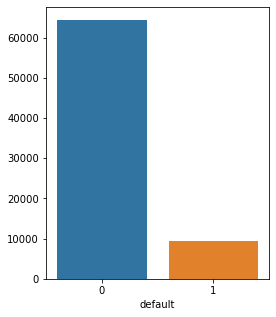

In [94]:
plt.figure(figsize=(4, 5))
ax = sns.countplot(x=train["default"])
ax.set(ylabel="");

## Некоторые функции

In [95]:
def outliers(df_col, df=data):
    # Определение наличия выбросов и их границ.
    
    q1 = df[df_col].quantile(0.25)
    q3 = df[df_col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    outliers = ((df[df_col] < low) | (df[df_col] > high)).sum()
    
    if not outliers:
        print(f"В признаке '{df_col}' выбросов нет\n")
        return

    print(f"Количество выбросов в признаке '{df_col}': {outliers}")
    print(f"25-й процентиль: {q1}, 75-й процентиль: {q3}, IQR: {iqr}, Границы выбросов: [{low}, {high}]\n")

In [96]:
# modified function from https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6
def features_to_drop(df, cut):
    """
    На основании коэффицентов корреляции определяет признаки, которые стоит удалить
    
    df - датафрейм
    cut - пороговое значение коэффициента корреляции
    """

    corr_mtx = df.corr() # создаём корреляционную матрицу
    avg_corr = corr_mtx.mean(axis=1) # считаем среднюю корреляцию по признакам, это будет критерием отбора признаков
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(bool)) 
    # создаём верхний треугольник матрицы 
    # нижний не несёт дополнительной информации, так как матрица корреляций симметрична

    drop = [] # будущий список признаков для удаления

    for row in range(len(up)-1): # проходимся по всем строкам матрицы
        for col in range(row + 1, len(up)): # проходимся по всем столбцам
            if(abs(corr_mtx.iloc[row, col]) > cut): # если корреляция двух текущих признаков больше пороговой,
                # то удалим один из них (тот, у которого средняя корреляция больше):
                if(abs(avg_corr.iloc[row]) > abs(avg_corr.iloc[col])):
                    drop.append(row)
                else:
                    drop.append(col)
                
    dropcols_names = list(df.columns[list(set(drop))])
    if dropcols_names:
        return dropcols_names
    print("Сильноскоррелированных переменных нет")

## Работа с пропусками

In [97]:
data.isna().sum()
# пропуски есть только в данных об образовании

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
train                 0
default               0
dtype: int64

In [98]:
data["education"].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [99]:
data["education"].fillna(data["education"].mode()[0], inplace=True)
data.isna().sum().sum()

0

## Работа с переменными

### 1.  Числовые признаки
* client_id - идентификатор
* age - возраст
* decline_app_cnt - количество отклонённых заявок
* score_bki - скоринговый балл
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* income - доход

In [100]:
data["client_id"].nunique() == data.shape[0]
# Видим, что id уникален для каждого клиента, поэтому его можно удалить

True

In [101]:
data.drop("client_id", axis=1, inplace=True)

In [102]:
num_cols = ["age", "decline_app_cnt", "score_bki", 
            "bki_request_cnt", "region_rating", "income"]

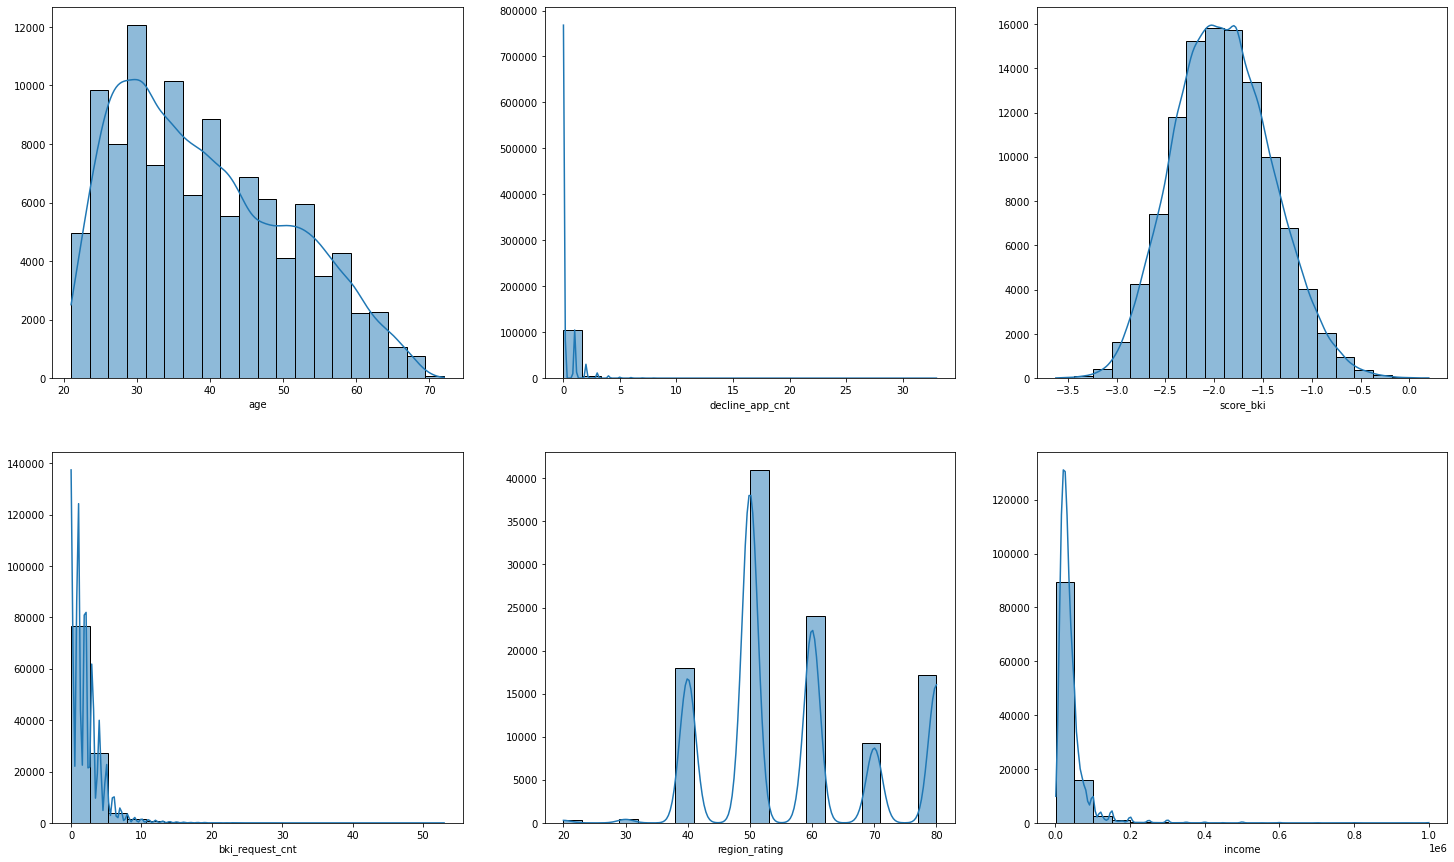

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i, col in enumerate(num_cols):
    hist = sns.histplot(data[col], bins=20, kde=True, ax=axes.flat[i])
    hist.set(ylabel="")

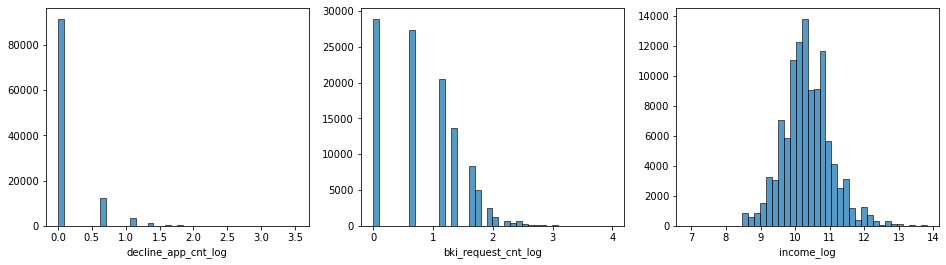

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(["decline_app_cnt", "bki_request_cnt", "income"]):
    num_cols.append(f"{col}_log")
    data[f"{col}_log"] = np.log(data[col] + 1)
    hist = sns.histplot(data[f"{col}_log"], bins=40, ax=axes.flat[i], kde=False)
    hist.set(ylabel="")

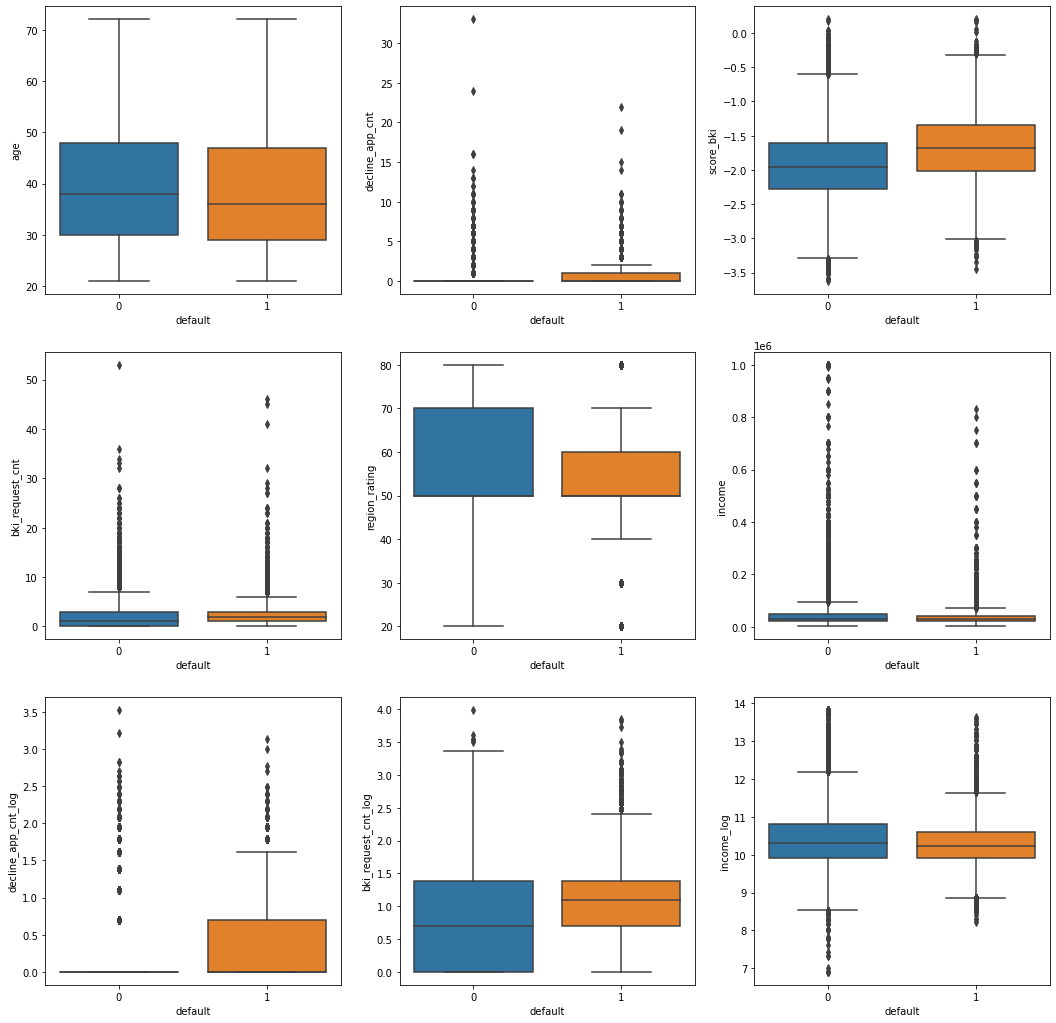

In [105]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data[data["default"]>=0], orient="v", ax=axes[i])
# видим, например, что у "хороших" клиентов в прошлом не было отказов на выдачу кредитов
# также у них более низкий скоринговый балл и меньше запросов в БКИ

Судя по графикам, выбросов очень много. Попробуем поработать с ними и понять, действительно ли это выбросы.

In [106]:
for col in num_cols:
    outliers(col)

В признаке 'age' выбросов нет

Количество выбросов в признаке 'decline_app_cnt': 18677
25-й процентиль: 0.0, 75-й процентиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]

Количество выбросов в признаке 'score_bki': 518
25-й процентиль: -2.2604336700000003, 75-й процентиль: -1.5678881525, IQR: 0.6925455175000004, Границы выбросов: [-3.299251946250001, -0.5290698762499992]

Количество выбросов в признаке 'bki_request_cnt': 2636
25-й процентиль: 0.0, 75-й процентиль: 3.0, IQR: 3.0, Границы выбросов: [-4.5, 7.5]

Количество выбросов в признаке 'region_rating': 17917
25-й процентиль: 50.0, 75-й процентиль: 60.0, IQR: 10.0, Границы выбросов: [35.0, 75.0]

Количество выбросов в признаке 'income': 7000
25-й процентиль: 20000.0, 75-й процентиль: 48000.0, IQR: 28000.0, Границы выбросов: [-22000.0, 90000.0]

Количество выбросов в признаке 'decline_app_cnt_log': 18677
25-й процентиль: 0.0, 75-й процентиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]

Количество выбросов в признаке 'bki_request_cnt

### 2.  Бинарные признаки
* sex - пол клиента
* car - флаг наличия машины
* car_type - флаг машины-иномарки
* good_work - флаг наличия "хорошей" работы
* foreign_passport - флаг наличия иностранного паспорта

In [107]:
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] 
# целевая переменная "default" также является бинарной 

In [175]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()



,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


In [188]:
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')



NameError: name 'mutual_info_classif' is not defined

### 3.  Категориальные признаки
* education - уровень образования
* home_address - категория домашнего адреса
* work_address - категория рабочего адреса
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о клиенте

In [108]:
cat_cols = ["education", "home_address", "work_address", "sna",  "first_time"]

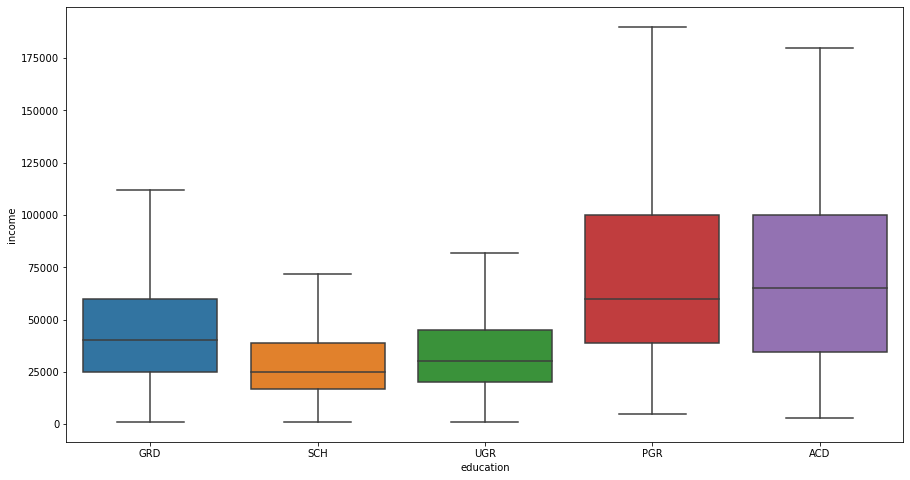

In [109]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False);
# посмотрим, влияет ли уровень образования на доход

__app_date__

In [110]:
data["app_date"]
# дата в неудобном формате, преобразуем её

0         22MAR2014
1         24JAN2014
2         23MAR2014
3         03FEB2014
4         04FEB2014
            ...    
110143    04MAR2014
110144    24MAR2014
110145    22APR2014
110146    04JAN2014
110147    23JAN2014
Name: app_date, Length: 110148, dtype: object

In [111]:
datetime_ = pd.to_datetime(data.app_date)
row = datetime_ - datetime_.min()
row[0]

Timedelta('80 days 00:00:00')

In [177]:
data["app_date"] = row.apply(lambda x: x.days)

## Feature engineering

In [178]:
mean_income = data.groupby("age")["income"].mean().to_dict()
data["mean_income"] = data["age"].map(mean_income)

In [179]:
max_income = data.groupby("age")["income"].max().to_dict()
data["max_income"] = data["age"].map(max_income)

In [180]:
data["normalized_income"] = abs(data.income - data.mean_income) / data.max_income

In [181]:
mean_income_reg = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_reg)

In [182]:
mean_bki_age = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_requests_age'] = data['age'].map(mean_bki_age)

In [183]:
mean_bki_inc = data.groupby('income')['bki_request_cnt'].mean().to_dict()
data['mean_requests_income'] = data['income'].map(mean_bki_inc)

In [184]:
num_cols = ["age", "decline_app_cnt", "score_bki", 
            "bki_request_cnt", "region_rating", "income", 
            "app_date", "mean_income", "max_income", 
            "normalized_income", "mean_income_region",
            "mean_requests_age", "mean_requests_income"]
# обновим список численных переменных, 

## Корреляционная матрица

In [120]:
corr = data.drop("train", axis=1).corr()
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)) 
for i in up.index:
    for col in up.columns:
        if i != col and abs(up.loc[i, col]) > 0.8:
                print(f"Признаки {i} и {col} имеют корреляцию {up.loc[i, col]:.3f}")
# видим, что высоко скоррелированы модифицированные признаки и их изначальные версии, а также home_address и work_address

Признаки decline_app_cnt и decline_app_cnt_log имеют корреляцию 0.932
Признаки bki_request_cnt и bki_request_cnt_log имеют корреляцию 0.895
Признаки region_rating и mean_income_region имеют корреляцию 0.917


In [121]:
for i in corr.drop("default", axis=1).columns:
    c = corr.loc[i, "default"]
    print(f"Корреляция между {i} и целевой переменной равна {c:.3f}")
# заметим, что все корреляции с целевой переменной очень низкие, меньше 0.1 по модулю

Корреляция между app_date и целевой переменной равна -0.012
Корреляция между age и целевой переменной равна -0.006
Корреляция между decline_app_cnt и целевой переменной равна 0.047
Корреляция между good_work и целевой переменной равна -0.018
Корреляция между score_bki и целевой переменной равна 0.065
Корреляция между bki_request_cnt и целевой переменной равна 0.026
Корреляция между region_rating и целевой переменной равна -0.036
Корреляция между home_address и целевой переменной равна 0.033
Корреляция между work_address и целевой переменной равна 0.028
Корреляция между income и целевой переменной равна -0.013
Корреляция между sna и целевой переменной равна 0.049
Корреляция между first_time и целевой переменной равна -0.040
Корреляция между decline_app_cnt_log и целевой переменной равна 0.051
Корреляция между bki_request_cnt_log и целевой переменной равна 0.028
Корреляция между income_log и целевой переменной равна -0.020
Корреляция между mean_income и целевой переменной равна -0.002
Ко

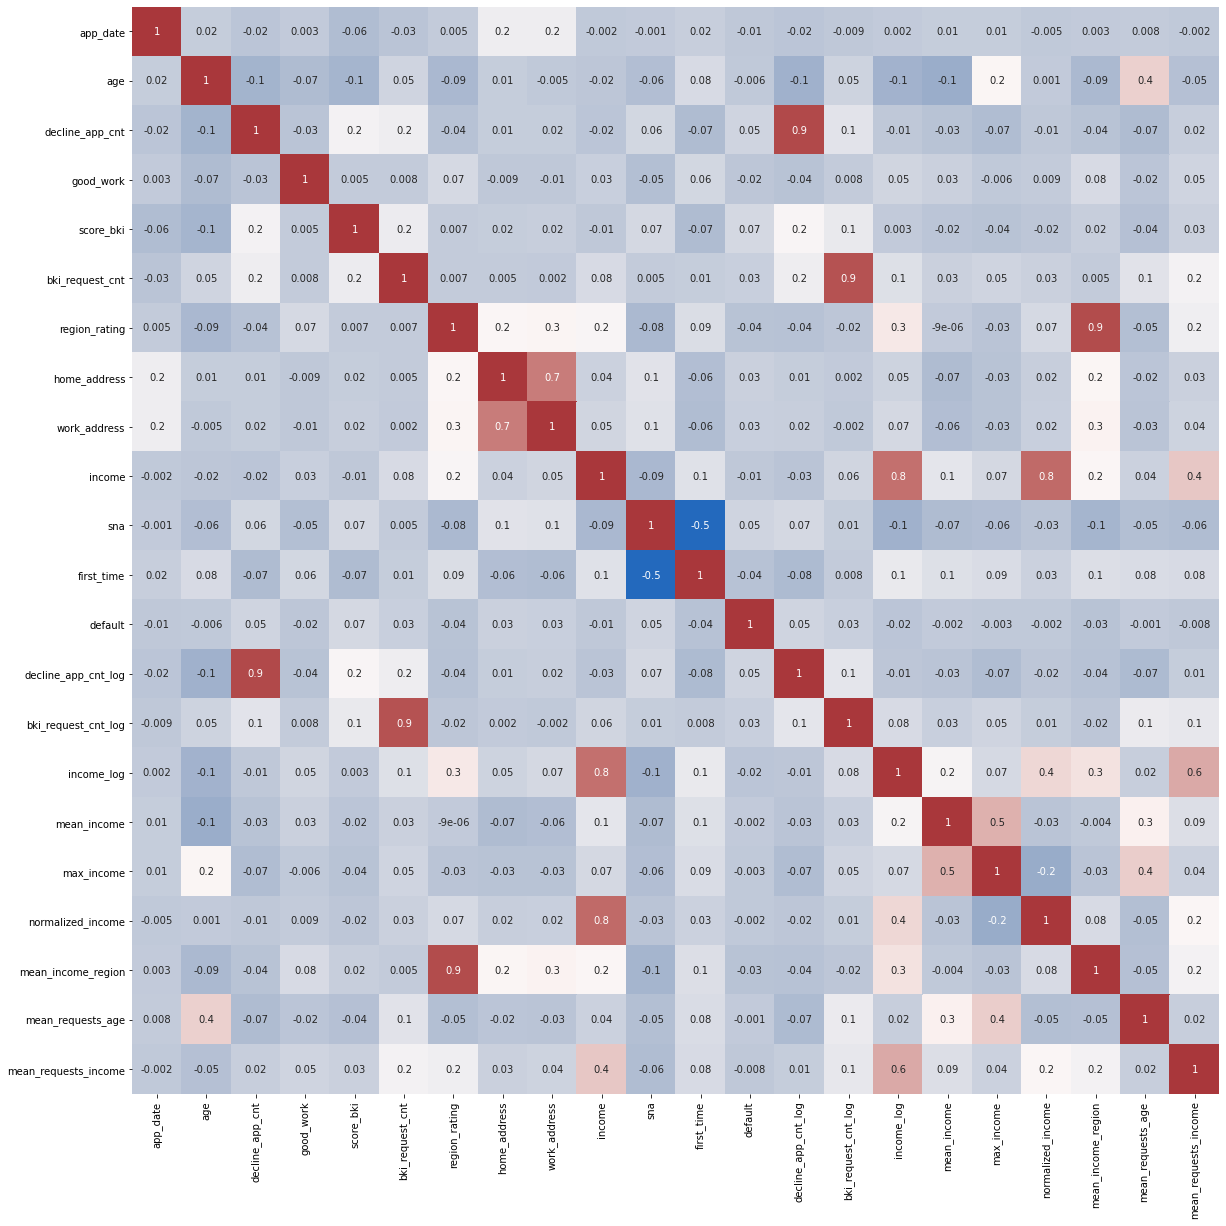

In [122]:
plt.rcParams['figure.figsize'] = (20, 20)
sns.heatmap(corr, cmap='vlag', annot=True, fmt='.1g', cbar=False, square=True);

In [123]:
determinant = np.prod(np.linalg.eig(corr)[0])
print(f"Determinant of the matrix is {determinant:.10f}")
# детерминант маленький, и это не радует

Determinant of the matrix is 0.0000150909


In [190]:
data.app_date.dtype

dtype('int64')

In [191]:
corr.isna().sum()

app_date                0
age                     0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
default                 0
decline_app_cnt_log     0
bki_request_cnt_log     0
income_log              0
mean_income             0
max_income              0
normalized_income       0
mean_income_region      0
mean_requests_age       0
mean_requests_income    0
dtype: int64

## Кодирование

In [126]:
data.dtypes

app_date                  int64
education                object
sex                      object
age                       int64
car                      object
car_type                 object
decline_app_cnt           int64
good_work                 int64
score_bki               float64
bki_request_cnt           int64
region_rating             int64
home_address              int64
work_address              int64
income                    int64
sna                       int64
first_time                int64
foreign_passport         object
train                     int64
default                   int64
decline_app_cnt_log     float64
bki_request_cnt_log     float64
income_log              float64
mean_income             float64
max_income                int64
normalized_income       float64
mean_income_region      float64
mean_requests_age       float64
mean_requests_income    float64
dtype: object

In [192]:
data["education"].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [128]:
df = data.copy()
enc = LabelEncoder()
for col in bin_cols:
    df[col] = enc.fit_transform(df[col])
df["education"] = enc.fit_transform(df["education"]) 
# закодируем данные об образовании - это корректно, так как переменная ординальная
df["education"].value_counts()

3    58476
1    34768
4    14748
2     1865
0      291
Name: education, dtype: int64

In [129]:
df.dtypes

app_date                  int64
education                 int32
sex                       int32
age                       int64
car                       int32
car_type                  int32
decline_app_cnt           int64
good_work                 int64
score_bki               float64
bki_request_cnt           int64
region_rating             int64
home_address              int64
work_address              int64
income                    int64
sna                       int64
first_time                int64
foreign_passport          int32
train                     int64
default                   int64
decline_app_cnt_log     float64
bki_request_cnt_log     float64
income_log              float64
mean_income             float64
max_income                int64
normalized_income       float64
mean_income_region      float64
mean_requests_age       float64
mean_requests_income    float64
dtype: object

## Отбор признаков

In [130]:
df[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns=num_cols)

In [131]:
drop = features_to_drop(df.drop("default", axis=1), cut=.8)
# найдём признаки, скоррелированные сильнее 0.85 по модулю
drop

['mean_income_region', 'bki_request_cnt', 'decline_app_cnt']

In [132]:
df.drop(drop, axis=1, inplace=True)

## Подготовка данных и обучение модели

In [193]:
train_df = df.query('train == 1').drop(['train'], axis=1)
test_df = df.query('train == 0').drop(['train'], axis=1)

In [134]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values

In [135]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [136]:
lr = LogisticRegression(max_iter = 1000)

In [137]:
lr.fit(X_train, y_train)
probs = lr.predict_proba(X_valid)[:, 1]

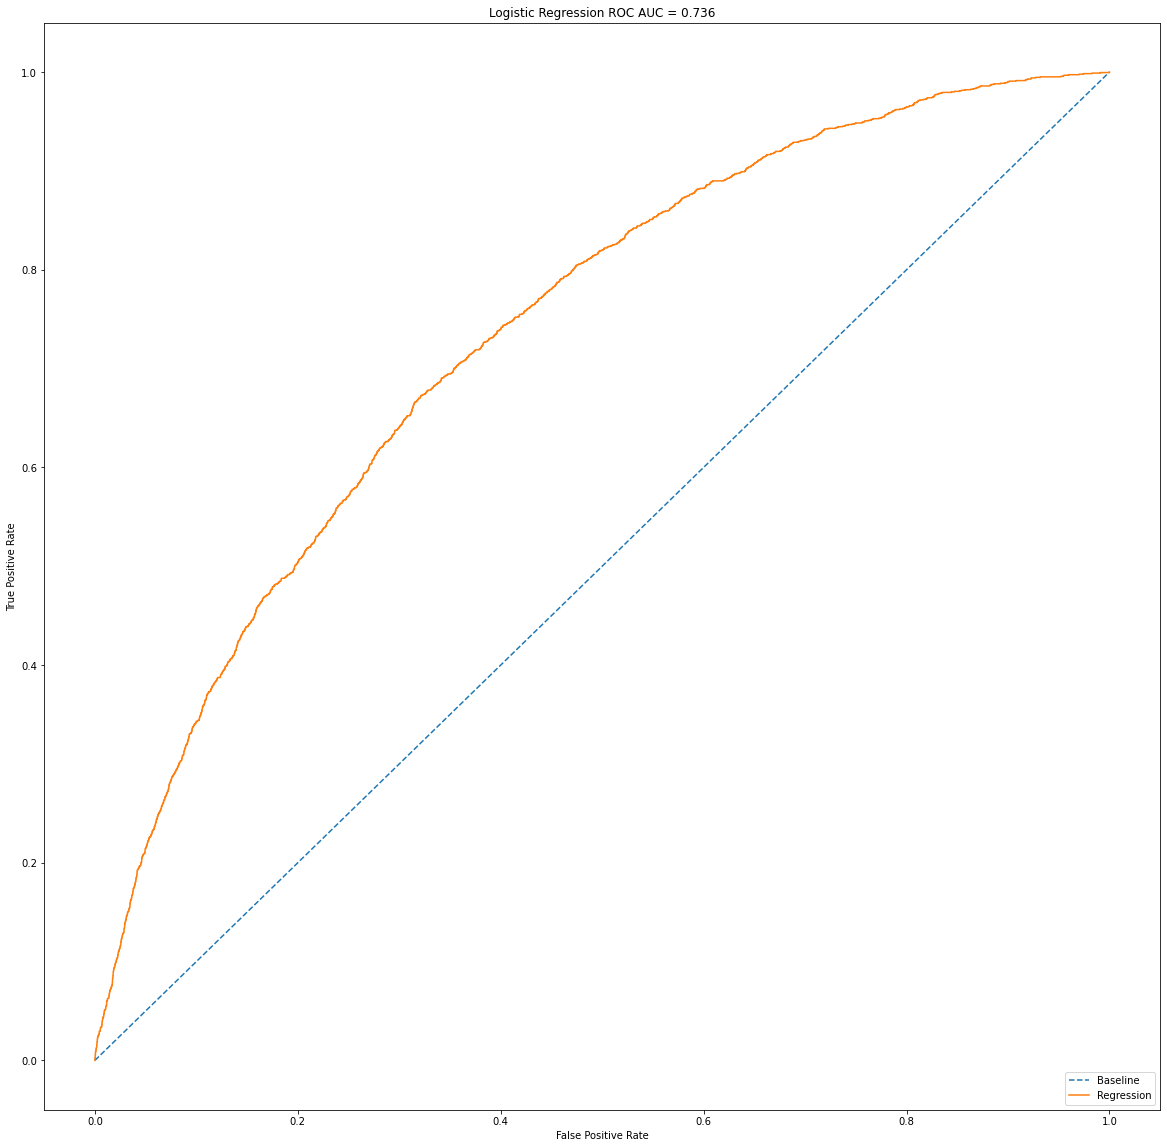

In [138]:
fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [139]:
probs = lr.predict_proba(X_valid)[:, 1]
probs[probs > .5] = 1
probs[probs <= .5] = 0
f1_score(probs, y_valid)
# f1-score пугающе низкий, посмотрим на корреляционную матрицу

0.05430327868852459

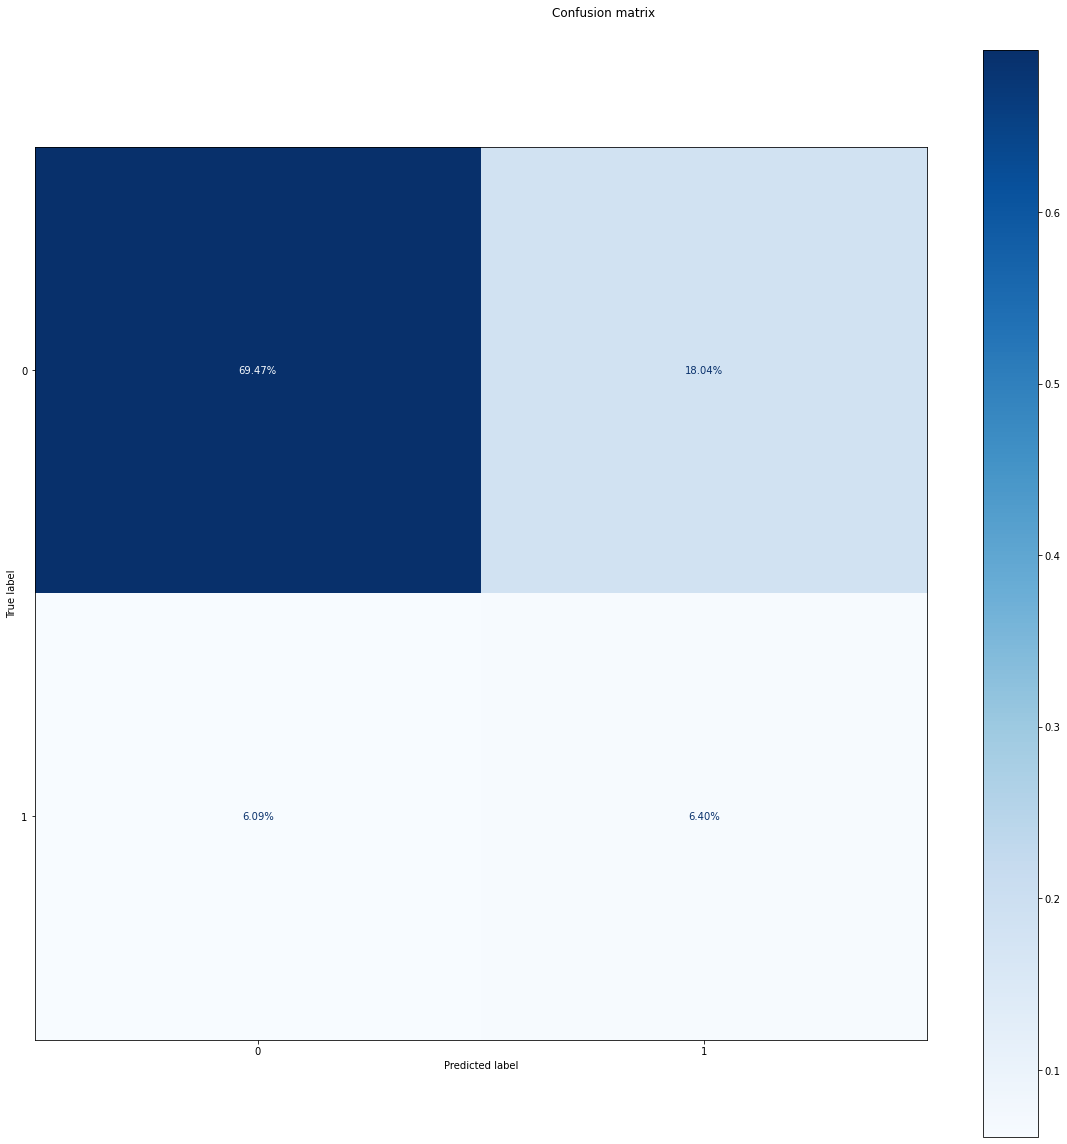

In [204]:
cm = confusion_matrix(y_valid, probs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/np.sum(cm), display_labels=lr.classes_) # или confusion_matrix=cm
disp.plot(cmap="Blues", values_format=".2%") # или values_format=".0f"
plt.suptitle("Confusion matrix", x=.52, y=.91);
# мы видим, что мы верно определили почти всех "хороших" клиентов, но также выдали кредиты и "плохим"
# попробуем уменьшить порог

In [141]:
probs = lr.predict_proba(X_valid)[:, 1]
probs[probs > .17] = 1
probs[probs <= .17] = 0 
# порог дефолта выбрали всего 0.17, иначе получалось, что одобряли кредиты всем
# да, мы отсекаем больше "хороших" клиентов, но зато меньше ошибаемся в плохих 
f1_score(probs, y_valid)

0.34642201834862385

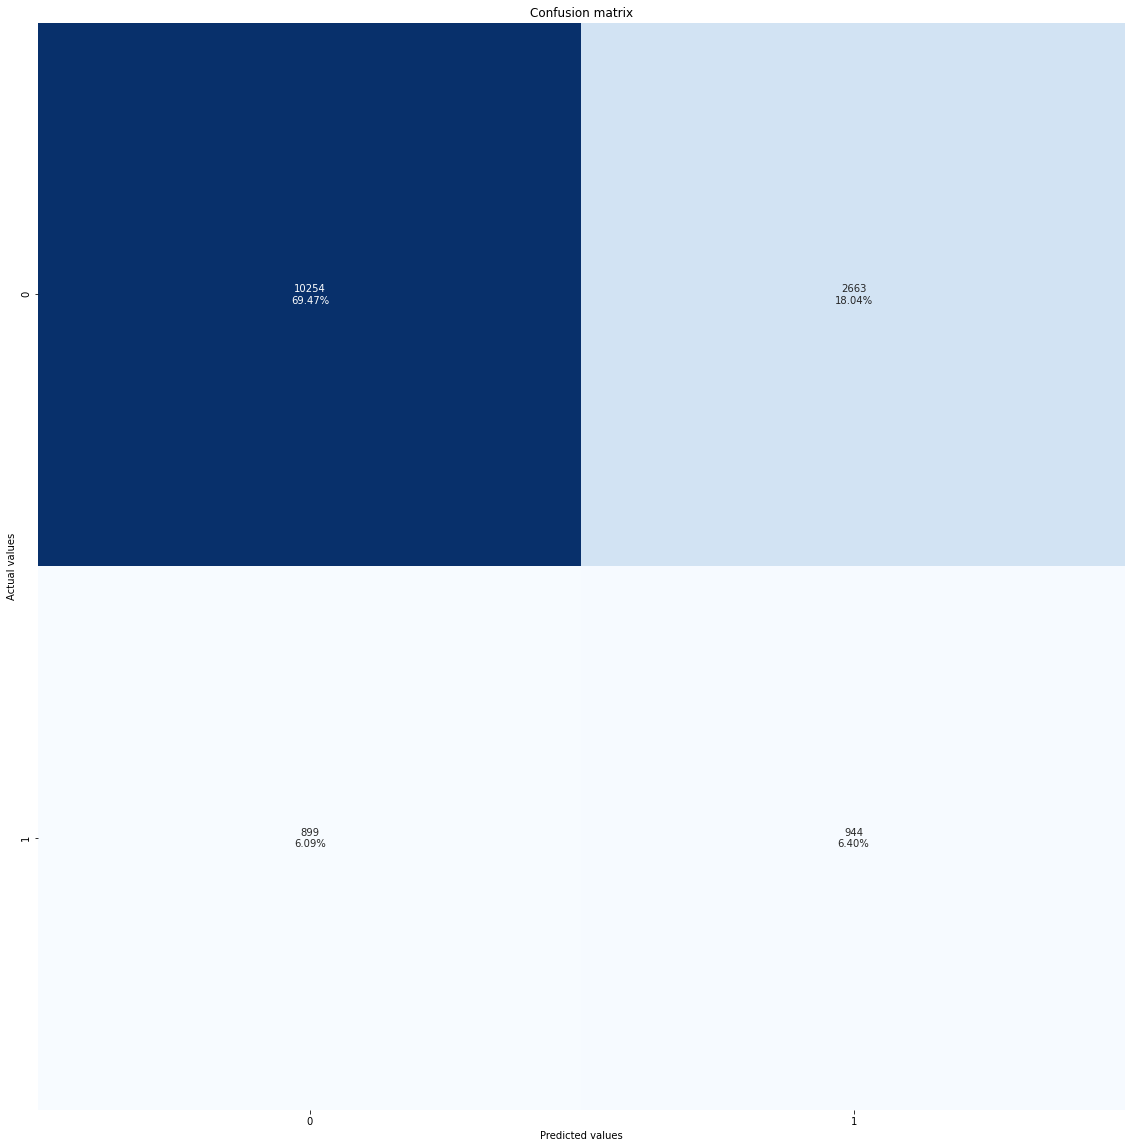

In [142]:
cm = confusion_matrix(y_valid, probs)
X = [str(i) for i in cm.flatten()]
Y = [f"{i:.2%}" for i in cm.flatten() / np.sum(cm)]
labels = np.asarray([x+"\n"+y for x, y in zip(X, Y)]).reshape(2, -1)
ax = sns.heatmap(cm, annot=labels, cbar=False, fmt='', cmap='Blues', square=True)
ax.set_title("Confusion matrix")
ax.set_xlabel("Predicted values")
ax.set_ylabel("Actual values");

In [143]:
y_pred = lr.predict_proba(test_df.drop(['default'], axis=1).values)[:, 1]

In [144]:
y_pred[y_pred > .17] = 1
y_pred[y_pred <= .17] = 0

In [157]:
result = pd.DataFrame(data={'client_id':test['client_id'], 'default': y_pred}).astype(int)
result.to_csv('submission.csv', index=False)
# public score вышел 0.34815 у нас чуть лучше


## Подбор гиперпараметров
раздел в раработке... sorry

In [203]:
from sklearn.model_selection import GridSearchCV
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l1'
	random_state: None
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
